# Lab 5 (a): Stable Diffusion + Dynamic Guidance Scheduler


Stable Diffusion is a powerful text-to-image model. There are various websites and tools to make using it as easy as possible. It is also [integrated into the Huggingface diffusers library](https://huggingface.co/blog/stable_diffusion) where generating images can be as simple as:
```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]

```

In this notebook we're going to dig into the code behind these easy-to-use interfaces, to see what is going on under the hood. We'll begin by re-creating the functionality above as a scary chunk of code, and then one by one we'll inspect the different components and figure out what they do. By the end of this notebook that same sampling loop should feel like something you can tweak and modify as you like.

## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [3]:
pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)


In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, DDIMScheduler
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

If you've loaded a pipeline, you can also access these components using `pipe.unet`, `pipe.vae` and so on.

In this notebook we aren't doing any memory-saving tricks - if you find yourself running out of GPU RAM, look at the pipeline code for inspiration with things like attention slicing, switching to half precision (fp16), keeping the VAE on the CPU and other modifications.

## The Variational Autoencoder (VAE)

The VAE can 'encode' an image into some sort of latent representation, and decode this back into an image. I've wrapped the code for this into a couple of functions here so we can see what this looks like in action:

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae = vae.to(torch_device)


def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [5]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58602  100 58602    0     0   505k      0 --:--:-- --:--:-- --:--:--  506k


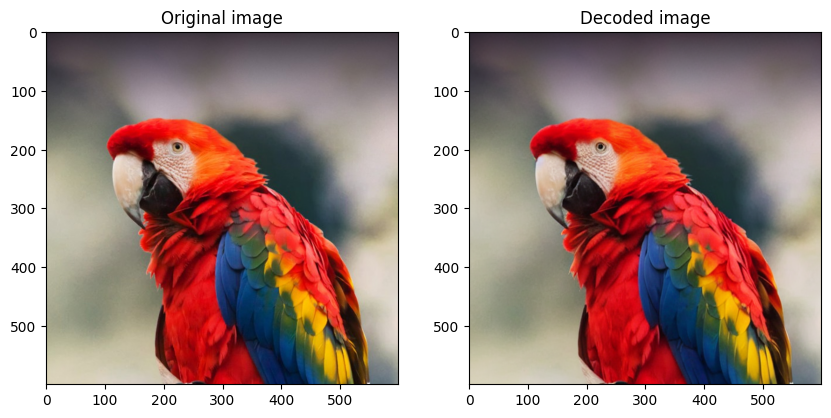

MSE: 19.92999537037037
PSNR: 35.135731630516595


/tmp/ipython-input-1818469608.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


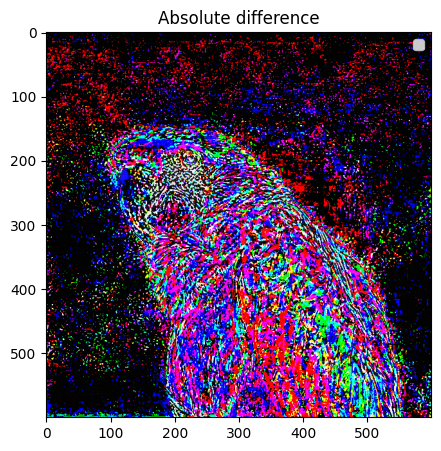

In [10]:
###############################################################################
# Complete the Code:
# Use VAE to encode and decode an image, then show the difference before and after re-decoding
# show MSE and PSNR, and abs diffed images:
# you can also test with your own images
##############################################################################

encoded_image = pil_to_latent(Image.open('macaw.jpg'))
decoded_image = latents_to_pil(encoded_image)[0]

# show before vs after
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(Image.open('macaw.jpg'))
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(decoded_image)
plt.title('Decoded image')
plt.show()

# and mse/psnr
mse = numpy.mean((numpy.array(Image.open('macaw.jpg')) - numpy.array(decoded_image)) ** 2)
psnr = 10 * numpy.log10(255 ** 2 / mse)
print('MSE:', mse)
print('PSNR:', psnr)

#absolute diffed images
plt.figure(figsize=(10, 5))
plt.imshow(numpy.abs(numpy.array(Image.open('macaw.jpg')) - numpy.array(decoded_image)))
plt.title('Absolute difference')
plt.show()

##############################################################################



# Task 1:
Fill the code of computing MSE and PSNR, as well as the code doing VAE and psnr.
Show the difference of image between ground truth and re-decoded images, report their metrics in PNSR (dB).
Extra: visualize each channel of VAE space matrice.



# Question 1:
Explain why we use VAE to encode image for diffusion, what could be the pros and cons.

# Answer:




# The Scheduler

The scheduler is in charge of noising images, in Huggingface, off-the-shelf scheduler are availible for us to explore:

IndexError: index 999 is out of bounds for dimension 0 with size 31

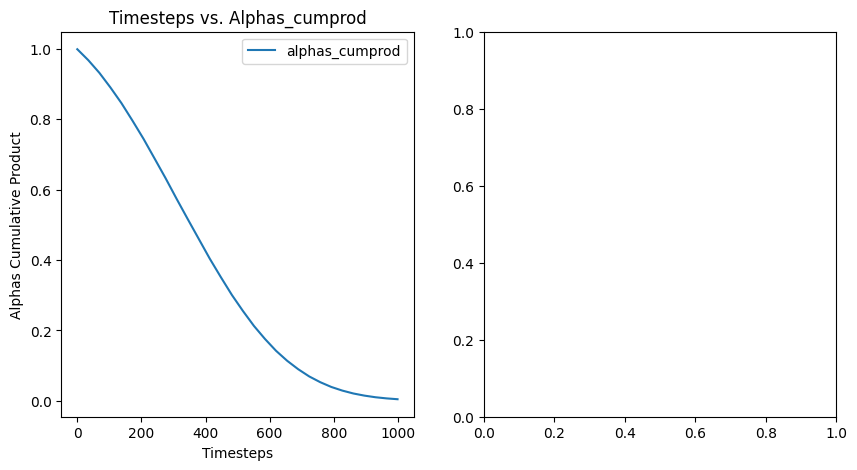

In [14]:

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
total_sampling_steps = 30
scheduler.set_timesteps(total_sampling_steps)
###############################################################################
# Complete the Code:
# plot scheduler's timesteps vs. alphas
# and plot also the SNR curve : check snr definition in https://arxiv.org/pdf/2107.00630.pdf
# check the manual of the scheduler we use LMSDiscreteScheduler in huggingface: https://huggingface.co/docs/diffusers/api/schedulers/lms_discrete
##############################################################################

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# Corrected: Index alphas_cumprod with scheduler.timesteps, ensure timesteps are long for indexing
plt.plot(scheduler.timesteps.cpu().numpy(), scheduler.alphas_cumprod[scheduler.timesteps.long()].cpu().numpy(), label='alphas_cumprod')
plt.title('Timesteps vs. Alphas_cumprod')
plt.xlabel('Timesteps')
plt.ylabel('Alphas Cumulative Product')
plt.legend()

plt.subplot(1, 2, 2)
# Calculate SNR: SNR = alphas_cumprod / (sigmas ** 2)
snr = scheduler.alphas_cumprod[scheduler.timesteps.long()] / (scheduler.sigmas[scheduler.timesteps.long()] ** 2)
plt.plot(scheduler.timesteps.cpu().numpy(), snr.cpu().numpy(), label='SNR')
plt.title("SNR curve")
plt.xlabel('Timesteps')
plt.ylabel('SNR')
plt.legend()
plt.show()

##############################################################################


In [ ]:
noise = torch.randn_like(encoded) # Random noise
scheduler.set_timesteps(30) # we do 30 steps, max timestep is 29
###############################################################################
# Complete the Code:
# Use the noise scheduler to noise your previous found latent with certain steps
# and show their evolution with different level of noises
# hint use the function: scheduler.add_noise / scheduler.set_timesteps / scheduler.timesteps
##############################################################################
# Fill me
##############################################################################



# Task 2:
Visualize the scheduler, and noise the encoded latent with your schedule, note down the change of image and also report the curve of psnr.


## Textual Embeddings

Remember we are going to do text2image generation, we need a good tool to encode text information.

In [ ]:
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = text_encoder.to(torch_device)

# Our text prompt
prompt = 'A pandas is eating bamboo'

We begin with tokenization:

In [ ]:
# Turn the text into a sequnce of tokens:
# we use tokenizers to tokenize the text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

In [ ]:
# See the individual tokens
for t in text_input['input_ids'][0][:10]: # We'll just look at the first words avoid seeing many '<|endoftext|>'
    ###############################################################################
    # Complete the Code:
    # Use tokenizer.decoder.get token to decode the tokens and show what they are
    # hint: check the manual about tokenizer.decoder
    ##############################################################################
    # Fill me
    ##############################################################################

Once we have the tokens, by putting them into the text_encoder, we could have the output_embeddings.

In [ ]:
# Grab the output embeddings
###############################################################################
# Complete the Code:
# Use text_encoder(token)[0] to output embeddings, remember we use the last_hidden_state so [0] is necessary
##############################################################################
# Fill me

print('Shape:', output_embeddings.shape)
assert output_embeddings.shape == torch.Size([1, 77, 768])
print(output_embeddings)

# Task 3:
Fill the code about tokenizer and embeddings.
Explain why the embedding shape is [1, 77, 768] and what the semantical meaning of each channel is.

## The UNET and CFG

In Stable Diffusion, A unet takes in the noisy latents (x) and predicts the noise. We use a conditional model that also takes in the timestep (t) and our text embedding (aka encoder_hidden_states) as conditioning. Feeding all of these into the model looks like this:
`noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]`


**Classifier Free Guidance**

To achive CFG this comes down to us doing:

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)`

See also the paper for more details https://arxiv.org/abs/2207.12598

In [ ]:
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# To the GPU
unet = unet.to(torch_device);

# Some settings
prompt = ["A pandas is eating bamboo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 6                # Scale for classifier-free guidance
generator = torch.manual_seed(13)   # Seed generator to create the inital latent noise
batch_size = 1

unconditional_prompt = ""

# Prep text

###############################################################################
# Complete the Code:
# generate uncond_embeddings and text_embeddings by tokenizer and text_encoder
##############################################################################
# Fill me
##############################################################################

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)
scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):

        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]

        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        ###############################################################################
        # Complete the Code:
        # you need to:
        # 1. predict noise_pred from unet().sample
        # 2. compute CFG by linearly combining the noise_pred_uncond and noise_pred_text
        # 3. use scheduler.step().prev_sample to do the denoising sampling, checkout the manual of scheduler.step()
        ##############################################################################
        # Fill me
        ################################################################################


# decode the latent to image
decoded = latents_to_pil(latents)[0]
decoded


# Task 4:
Fill in the code for the diffusion process: implement classifier-free guidance (CFG) and denoising sampling.
Try different values for guidance scale, random seeds, samplers, prompts, and the number of sampling steps.
Use these variations to build an image gallery and experiment to see the effects!

# Question 2:
In your opinion, what parameters most influence image quality in diffusion models?
How can we evaluate the quality of images generated by generative models?

# Answer:

# Task 5: Dynamic (Non-Constant) Guidance Schedulers
In standard CFG (Classifier-Free Guidance), the guidance scale is usually a fixed constant. However, recent research (see https://arxiv.org/html/2404.13040v1) suggests that ng a monotonically increasing guidance scale schedule (where guidance grows through the denoising steps) can improve output quality and diversity.
Your task:
- Implement a dynamic CFG schedule (e.g., linearly increasing guidance scale from low to high across diffusion steps).
- Feel free to wrap your logic in a function for clarity and reusability.
- Experiment with several prompts of your choice (such as "flowers in a red vase") and compare results to constant CFG scale.
- (Optional) Try other schedules (e.g., + clamp, cosine) and visualize the difference if you wish.


In [ ]:

###############################################################################
# Complete the Code:
# Copy paste your previous CFG code/or make a function then call it
# Implement here the dynamic CFG scheduler e.g., Linear one.
# Consider define it as a function to call:
# guidance_scale = guidance_scheduler[int(t)] # t is the timestep
##############################################################################
# Fill me
##############################################################################
